Download and extract data.


In [1]:
# remove all files present
!rm -rfv ./*
#download dataset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri" -O Data.zip && rm -rf /tmp/cookies.txt
# unzip
!unzip -q Data.zip
# remove zip 
!rm -rf ./Data.zip


removed './sample_data/anscombe.json'
removed './sample_data/README.md'
removed './sample_data/california_housing_test.csv'
removed './sample_data/mnist_test.csv'
removed './sample_data/mnist_train_small.csv'
removed './sample_data/california_housing_train.csv'
removed directory './sample_data'
--2020-08-17 09:04:00--  https://docs.google.com/uc?export=download&confirm=aDoK&id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri
Resolving docs.google.com (docs.google.com)... 172.217.219.102, 172.217.219.101, 172.217.219.100, ...
Connecting to docs.google.com (docs.google.com)|172.217.219.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-as-docs.googleusercontent.com/docs/securesc/higee6nkaj66hq1g41b38811doqm5pnk/mqkrdko8hhiuolcbva2tckiecq0vjk1l/1597655025000/07496480791912752493/15693273121189572850Z/1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri?e=download [following]
--2020-08-17 09:04:00--  https://doc-10-as-docs.googleusercontent.com/docs/securesc/higee6

In [2]:
# code block 1
# import
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
print(tf.__version__)
tf.random.set_seed(12345)
import glob

2.3.0


In [3]:
# code block 2
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE
Batch_Size = 50 #batch size used in the code.
KNeghb = 6 #Number to top N images needed.
PATHS = glob.glob('./dataset/*.jpg')
IMG_SHAPE = (224,224,3)
print(PATHS[:5])
Val = int(len(PATHS)*0.9)

def decode_image(filename, label=None, image_size=IMG_SHAPE[:-1]):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    return image
def create_dataset(path, image_size = None):
  dataset = (
      tf.data.Dataset
      .from_tensor_slices(PATHS)
      .map(decode_image, num_parallel_calls=AUTO)
      .batch(Batch_Size)
  )
  return dataset

['./dataset/1059.jpg', './dataset/1711.jpg', './dataset/1022.jpg', './dataset/283.jpg', './dataset/2247.jpg']


In [4]:
Train_dataset = create_dataset(PATHS[:Val])
Test_dataset = create_dataset(PATHS[Val:])

Till now we have downloaded created the datapipeline now we should proceed with the problem that is finding similar N images.


# Creating AutoEncoder to train our own CNN.

The main theme is to extract feature from the images and then use them to find the similar images.

In version 1 we have used the pretrained model to get the results in this part we will try to create our own model from scratch and train it.

For this task we will use CNN autoencoder to as it is a image dataset and CNN can learn it much efficently than normal FeedForward network.

In [5]:
import os

class AutoEncoder():
  def __init__(self,imageSize):
    self.IMG_SIZE = imageSize
    self.encoder = None
    self.autoencoder = None

  def make(self):

    # AlexNet inspired encoder.     
    input = tf.keras.layers.Input(shape=self.IMG_SIZE)
    x = tf.keras.layers.Conv2D(96, (11,11), strides = 4, activation='relu', padding='same',kernel_initializer= 'he_normal')(input)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)
    x = tf.keras.layers.Conv2D(256, (5,5), strides = 1, activation='relu', padding='same',kernel_initializer= 'he_normal')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)
    x = tf.keras.layers.Conv2D(384, (3,3), strides =1 , activation='relu', padding='same',kernel_initializer= 'he_normal')(x)
    x = tf.keras.layers.Conv2D(384, (3,3), strides =1 , activation='relu', padding='same',kernel_initializer= 'he_normal')(x)
    x = tf.keras.layers.Conv2D(256, (3,3), strides =1 , activation='relu', padding='same',kernel_initializer= 'he_normal')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)
    encoded = tf.keras.layers.Flatten()(x)
    #encoded = tf.keras.layers.Dense(4096, activation= 'relu')(x)
    
    x = tf.keras.layers.Reshape((7, 7, 256))(encoded)
    x = tf.keras.layers.UpSampling2D(size=(2,2))(x)
    x = tf.keras.layers.Conv2DTranspose(256, (3,3), strides =1 , activation='relu', padding='same',kernel_initializer= 'he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(384, (3,3), strides =1 , activation='relu', padding='same',kernel_initializer= 'he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(384, (3,3), strides =1 , activation='relu', padding='same',kernel_initializer= 'he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.UpSampling2D(size=(2,2))(x)
    x = tf.keras.layers.Conv2DTranspose(256, (5,5), strides = 1, activation='relu', padding='same',kernel_initializer= 'he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.UpSampling2D(size=(2,2))(x)
    x = tf.keras.layers.Conv2DTranspose(96, (11,11), strides = 4, activation='relu', padding='same',kernel_initializer= 'he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    decoded = tf.keras.layers.Conv2D(self.IMG_SIZE[2], (3,3),activation='sigmoid', padding='same')(x)

    # create encoder model
    encoder = tf.keras.Model(input, encoded)
    print(f"Encoder lastConv shape is {encoder.layers[-2].output_shape[1:]}")
    print(f"Encoder output shape is {encoder.layers[-1].output_shape[1:]}")
    # creating model
    autoencoder = tf.keras.Model(input,decoded)
    print(f"Autoencoder input shape is {autoencoder.layers[0].input_shape[1:]}")
    print(f"Autoencoder output shape is {autoencoder.layers[-1].output_shape[1:]}")

    # Summary
    print("\n Autoencoder summary:- ")
    print(autoencoder.summary())
    print("\n Encoder summary :- ")
    print(encoder.summary())
    
    self.encoder = encoder
    self.autoencoder = autoencoder

  # Compile
  def compile(self, loss="binary_crossentropy", optimizer="adam"):
    self.autoencoder.compile(optimizer=optimizer, loss=loss)

  # train model:-
  def fit(self, train,test, epoch_ = 15,batch_size=256):
    data_augmentation = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
          tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
          tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2,0.2)
        ])
    test_data = tf.data.Dataset.zip((test, test))
    if aug_:      
      aug_train = train.map(lambda x: data_augmentation(x, training=True))
      train_data = tf.data.Dataset.zip((aug_train, aug_train))
    else:
      train_data = tf.data.Dataset.zip((train, train))
    # checkpoint
    filepath="train/checkpoint.h5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    self.autoencoder.fit(train_data,
                          epochs = epoch_,
                          batch_size = batch_size,callbacks=callbacks_list,
                          validation_data = test_data)


  # Save model architecture and weights to file
  def save_models(self,folderpath):
    os.mkdir(folderpath)
    print("Saving models...")
    self.autoencoder.save(folderpath+"/autoencoder.h5")
    self.encoder.save(folderpath+"/encoder.h5")

  # Load model architecture and weights
  def load_models(self, folderpath, loss="binary_crossentropy", optimizer='adam'):
    print("Loading models...")
    if os.path.exists(folderpath+"/autoencoder.h5"):
      self.autoencoder = tf.keras.models.load_model(folderpath+"/autoencoder.h5")
      self.encoder = tf.keras.models.load_model(folderpath+"/encoder.h5")
      self.autoencoder.compile(optimizer=optimizer, loss=loss)
      self.encoder.compile(optimizer=optimizer, loss=loss)
    else:
      raise Exception("Invalid path given!")


  # get feature
  def get_feature(self, X):
    return self.encoder.predict(X)







In [6]:
len(PATHS)

4738

In [ ]:
# using autoencoder 
model = AutoEncoder(IMG_SHAPE)
model.make()
path = "./out"
if not os.path.exists(path):
  model.compile(loss="MSE", optimizer="adam")
  model.fit(train= Train_dataset,test = Test_dataset, batch_size=Batch_Size)
  model.save_models(path)

else:
  model.load_models(path,loss="MSE", optimizer="adam")

In [8]:
model.save_models(path)

Saving models...


lets see how the autoencoder is performing


input:- 


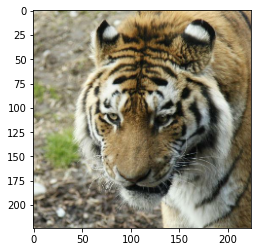

output:- 


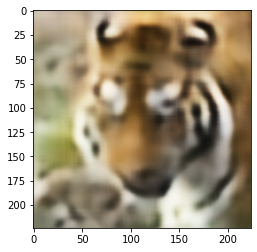

In [9]:
import matplotlib.pyplot as plt
image = decode_image('./dataset/0.jpg')
print("input:- ")
plt.imshow(image)
plt.show()
print("output:- ")
image = tf.expand_dims(image,axis=0)
plt.imshow(tf.squeeze(model.autoencoder.predict(image)))
plt.show()

In [10]:
# run it only once
import h5py
import numpy as np
import os

def save_prediction_simple(dataset,model):
  path = './out.h5'
  out_shape = model.encoder.layers[-1].output_shape[1:]
  if not os.path.exists(path):
    with h5py.File(path, "w") as f:
      pred = model.get_feature(dataset)
      f.create_dataset("Feature_map",  data=pred)

Now we have extracted the feature of all the images in the data set. lets now compare them with the query image. This to obtain the cosine similarity.

In [11]:
import h5py
from sklearn.neighbors import NearestNeighbors

def get_KNN(file_input, KNeghb):
  knn = NearestNeighbors(n_neighbors=KNeghb, metric="cosine")
  with h5py.File(file_input, "r") as f:
    features = f['Feature_map']
    print(features.shape)
    print("Fitting k-nearest-neighbour model on training images...")
    knn.fit(features)
    f.close()
  return knn



In [12]:
import numpy as np
import matplotlib.pyplot as plt
def plot_query_retrieval(img_query, imgs_retrieval, outFile):
    n_retrieval = len(imgs_retrieval)
    fig = plt.figure(figsize=(2*n_retrieval, 4))
    fig.suptitle("Image Retrieval (k={})".format(n_retrieval), fontsize=25)

    # Plot query image
    ax = plt.subplot(2, n_retrieval, 0 + 1)
    plt.imshow(decode_image(img_query))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(4)  # increase border thickness
        ax.spines[axis].set_color('black')  # set to black
    ax.set_title("query",  fontsize=14)  # set subplot title

    # Plot retrieval images
    for i, img in enumerate(imgs_retrieval):
        ax = plt.subplot(2, n_retrieval, n_retrieval + i + 1)
        plt.imshow(decode_image(img))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(1)  # set border thickness
            ax.spines[axis].set_color('black')  # set to black
        ax.set_title("Rank #%d" % (i+1), fontsize=14)  # set subplot title

    if outFile is None:
        plt.show()
    else:
        plt.savefig(outFile, bbox_inches='tight')
    plt.close()

In [13]:
def get_n_images(query,knn,model):
  out_shape = model.encoder.layers[-1].output_shape[1:]
  image = decode_image(query)
  image = tf.expand_dims(image,axis=0)
  query_feature = model.get_feature(image)
  flat_query_feature = query_feature.reshape((-1,np.prod(out_shape)))
  _, indices = knn.kneighbors(flat_query_feature)
  imgs_retrieval = [PATHS[idx] for idx in indices.flatten()]
  plot_query_retrieval(query, imgs_retrieval, None)

(4738, 12544)
Fitting k-nearest-neighbour model on training images...


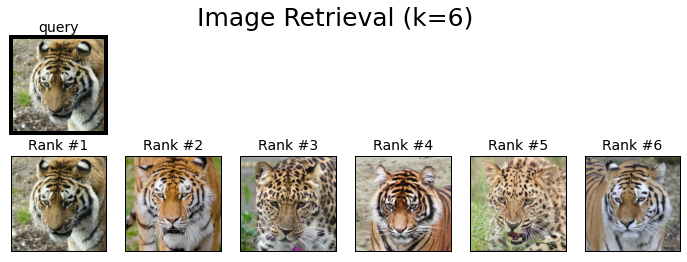

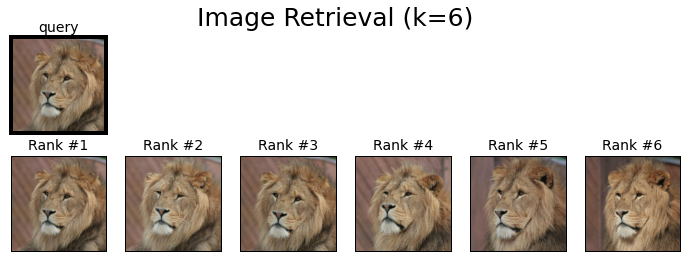

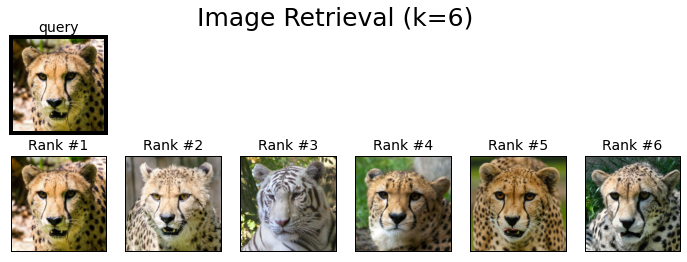

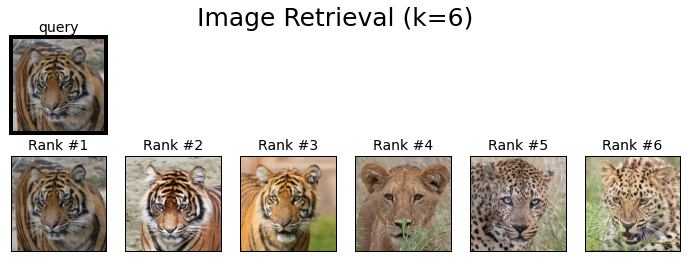

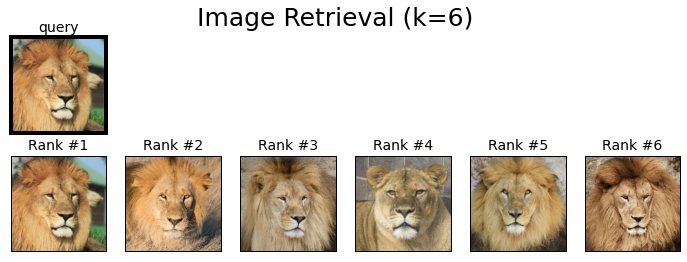

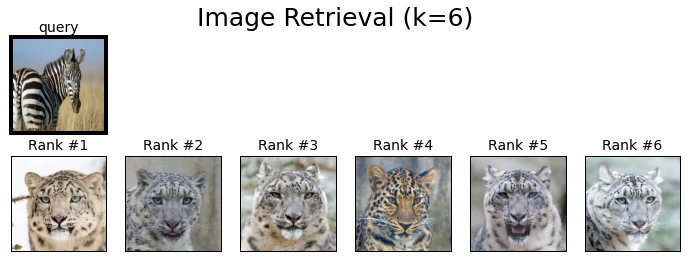

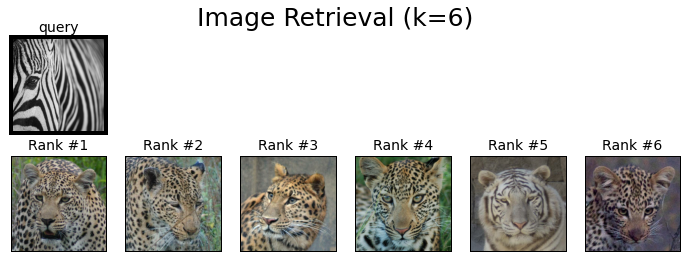

In [14]:
#save the prediction
save_prediction_simple(Train_dataset,model)
#re train the KNN
knn = get_KNN('out.h5',KNeghb)
# Get results
get_n_images('./dataset/0.jpg',knn,model)
get_n_images('./dataset/3.jpg',knn,model)
get_n_images('./dataset/9.jpg', knn, model)
get_n_images(PATHS[Val:][0], knn, model)
get_n_images(PATHS[Val:][5], knn, model)
get_n_images('zebra.jpg', knn, model)
get_n_images('zebra2.jpg', knn, model)

# Please dont consider below for evaluation.

In [15]:
for i,layer in enumerate(model.autoencoder.layers):
  if i > 9:
    layer.trainable = False
    print(f"{layer.name} -> {layer.trainable}")
  else:
    print(f"{layer.name} -> {layer.trainable}")

input_1 -> True
conv2d -> True
max_pooling2d -> True
conv2d_1 -> True
max_pooling2d_1 -> True
conv2d_2 -> True
conv2d_3 -> True
conv2d_4 -> True
max_pooling2d_2 -> True
flatten -> True
reshape -> False
up_sampling2d -> False
conv2d_transpose -> False
batch_normalization -> False
conv2d_transpose_1 -> False
batch_normalization_1 -> False
conv2d_transpose_2 -> False
batch_normalization_2 -> False
up_sampling2d_1 -> False
conv2d_transpose_3 -> False
batch_normalization_3 -> False
up_sampling2d_2 -> False
conv2d_transpose_4 -> False
batch_normalization_4 -> False
conv2d_5 -> False


In [ ]:
model.compile(loss = "MSE", optimizer='adam')
model.fit(train= Train_dataset,test = Test_dataset, epoch_ = 5, batch_size=Batch_Size)
model.save_models(path)

input:- 


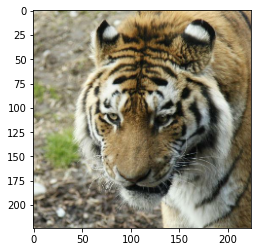

output:- 


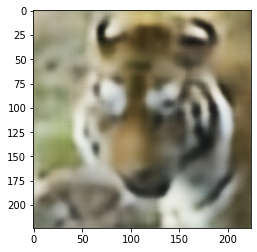

In [17]:
#Get autoencoder performance
import matplotlib.pyplot as plt
image = decode_image('./dataset/0.jpg')
print("input:- ")
plt.imshow(image)
plt.show()
print("output:- ")
image = tf.expand_dims(image,axis=0)
plt.imshow(tf.squeeze(model.autoencoder.predict(image)))
plt.show() 

(4738, 12544)
Fitting k-nearest-neighbour model on training images...


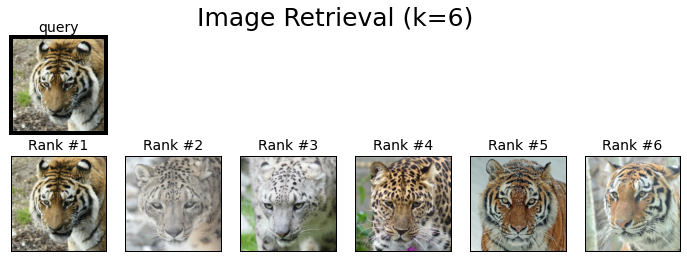

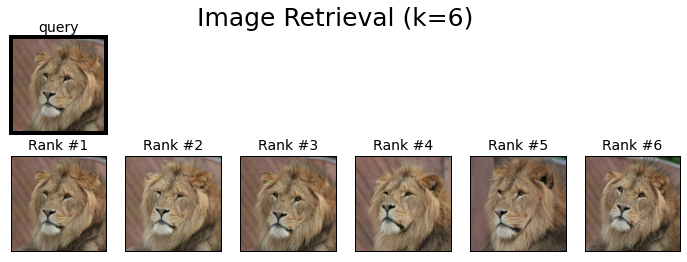

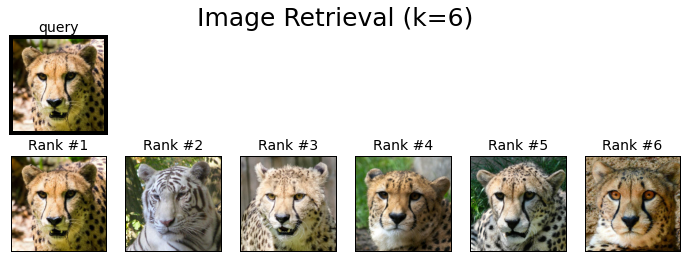

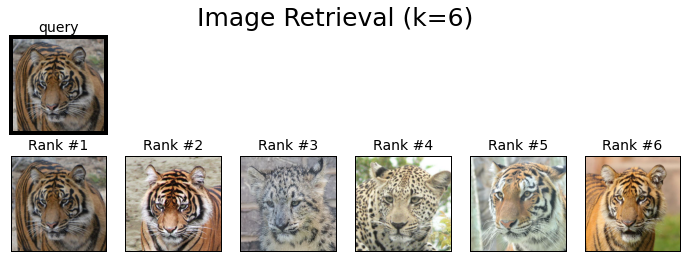

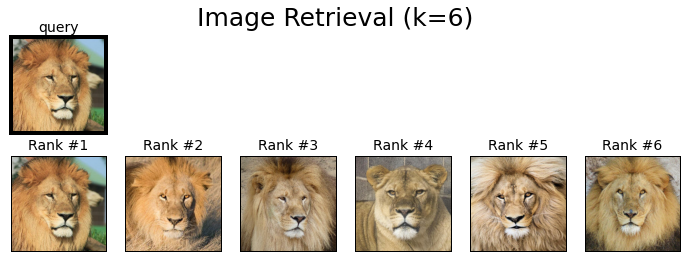

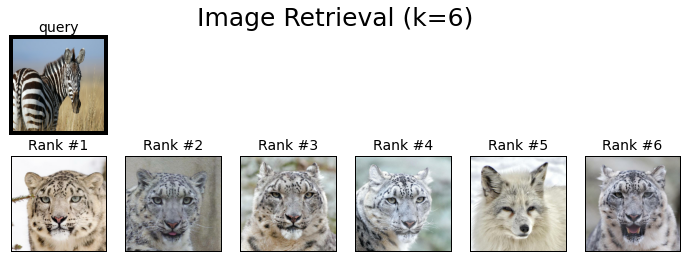

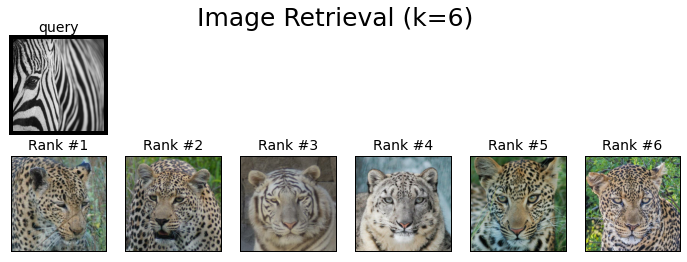

In [18]:
#save the prediction
save_prediction_simple(Train_dataset,model)
#re train the KNN
knn = get_KNN('out.h5',KNeghb)
# Get results
get_n_images('./dataset/0.jpg',knn,model)
get_n_images('./dataset/3.jpg',knn,model)
get_n_images('./dataset/9.jpg', knn, model)
get_n_images(PATHS[Val:][0], knn, model)
get_n_images(PATHS[Val:][5], knn, model)
get_n_images('zebra.jpg', knn, model)
get_n_images('zebra2.jpg', knn, model)

As we can see fine tunning actully doent improve our model much thus, we can just move with the output obtained from the first train only.